In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd 'filepath of data'

filepath of data


In [6]:
## Importing required modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import random

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import tensorflow as tf
import os 
from skimage import io
from PIL import Image
from tensorflow.keras import backend as K
  
#creating a custom datagenerator:

class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = './' + str(list_ids[i])
      
      #mask path
      mask_path = './' + str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y






def prediction(test, model, model_seg):
  '''
  Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image
  Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model
  is 99% sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the
  segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found
  '''

  #directory
  directory = "./"

  #Creating empty list to store the results
  mask = []
  image_id = []
  has_mask = []

  #iterating through each image in the test data
  for i in test.image_path:

    path = directory + str(i)

    #reading the image
    img = io.imread(path)

    #Normalizing the image
    img = img * 1./255.

    #Reshaping the image
    img = cv2.resize(img,(256,256))

    #Converting the image into array
    img = np.array(img, dtype = np.float64)
    
    #reshaping the image from 256,256,3 to 1,256,256,3
    img = np.reshape(img, (1,256,256,3))

    #making prediction on the image
    is_defect = model.predict(img)

    #if tumour is not present we append the details of the image to the list
    if np.argmax(is_defect) == 0:
      image_id.append(i)
      has_mask.append(0)
      mask.append('No mask')
      continue

    #Read the image
    img = io.imread(path)

    #Creating a empty array of shape 1,256,256,1
    X = np.empty((1, 256, 256, 3))

    #resizing the image and coverting them to array of type float64
    img = cv2.resize(img,(256,256))
    img = np.array(img, dtype = np.float64)

    #standardising the image
    img -= img.mean()
    img /= img.std()

    #converting the shape of image from 256,256,3 to 1,256,256,3
    X[0,] = img

    #make prediction
    predict = model_seg.predict(X)

    #if the sum of predicted values is equal to 0 then there is no tumour
    if predict.round().astype(int).sum() == 0:
        image_id.append(i)
        has_mask.append(0)
        mask.append('No mask')
    else:
    #if the sum of pixel values are more than 0, then there is tumour
        image_id.append(i)
        has_mask.append(1)
        mask.append(predict)


  return image_id, mask, has_mask
        




'''
We need a custom loss function to train this ResUNet.So,  we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py


@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}
'''
def tversky(y_true, y_pred, smooth = 1e-6):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    ## IMPORTANT NOTE:
    ## It seems that the type of y_true and y_pred are not the same. One is of type
    ## float32 and other int64. They need to be cast as the same type for the training
    ## to actually work.
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    #print(type(y_pred))
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [8]:
testing_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AI Program/AI in Healthcare/Brain_MRI/testing_ds.csv')
#testing_df = testing_df.drop(columns= ['patient_id'])

In [9]:
## Loading up resnet50 model
import json
with open('tumor_resnet50_arch.json', 'r') as json_file:
  resnet50 = json_file.read()

model = tf.keras.models.model_from_json(resnet50)
model.load_weights('tumor_resnet50_weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [10]:
with open('/content/drive/My Drive/Colab Notebooks/AI Program/AI in Healthcare/Brain_MRI/ResUNet_architecture.json','r') as json_file:
  resunet = json_file.read()

model_resunet = tf.keras.models.model_from_json(resunet)
model_resunet.load_weights('ResUNet_mask.hdf5')
model_resunet.compile(optimizer = tf.keras.optimizers.Adam(lr = .05, epsilon = 0.1), loss = focal_tversky, metrics = [tversky])


In [11]:
image_id, mask, has_mask = prediction(testing_df, model, model_resunet)

In [12]:
## Appending results to df
df_prediction = pd.DataFrame({'image_path': image_id, 'prediction': mask, 'valid': has_mask})

In [14]:
df_prediction

,image_path,prediction,valid
0,TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_14...,"[[[[3.2670296e-06], [1.93836e-06], [1.1984419e...",1
1,TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_15...,"[[[[2.1407077e-06], [2.1371034e-06], [1.974572...",1
2,TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_21...,No mask,0
3,TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_1.tif,No mask,0
4,TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_51...,No mask,0
...,...,...,...
585,TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_36...,No mask,0
586,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_9.tif,No mask,0
587,TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_2.tif,No mask,0
588,TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_5.tif,No mask,0


In [15]:
## Adding predictions to test dataset for visualization
df_prediction = testing_df.merge(df_prediction, on = 'image_path')

In [16]:
df_prediction

,Unnamed: 0,patient_id,image_path,mask_path,mask,prediction,valid
0,1524,TCGA_DU_7302_19911203,TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_14...,TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_14...,1,"[[[[3.2670296e-06], [1.93836e-06], [1.1984419e...",1
1,1586,TCGA_DU_A5TS_19970726,TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_15...,TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_15...,1,"[[[[2.1407077e-06], [2.1371034e-06], [1.974572...",1
2,2246,TCGA_FG_7634_20000128,TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_21...,TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_21...,0,No mask,0
3,46,TCGA_CS_4941_19960909,TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_1.tif,TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_1_...,0,No mask,0
4,3701,TCGA_FG_6688_20020215,TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_51...,TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_51...,0,No mask,0
...,...,...,...,...,...,...,...
585,3277,TCGA_HT_A61A_20000127,TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_36...,TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_36...,0,No mask,0
586,947,TCGA_DU_6405_19851005,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_9.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_9_...,0,No mask,0
587,199,TCGA_CS_6666_20011109,TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_2.tif,TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_2_...,0,No mask,0
588,508,TCGA_DU_5874_19950510,TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_5.tif,TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_5_...,0,No mask,0


In [57]:
## Visualizing the results
visualization = df_prediction[df_prediction['valid'] == 1]
visualization

,Unnamed: 0,patient_id,image_path,mask_path,mask,prediction,valid
0,1524,TCGA_DU_7302_19911203,TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_14...,TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_14...,1,"[[[[3.2670296e-06], [1.93836e-06], [1.1984419e...",1
1,1586,TCGA_DU_A5TS_19970726,TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_15...,TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_15...,1,"[[[[2.1407077e-06], [2.1371034e-06], [1.974572...",1
8,775,TCGA_DU_6404_19850629,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_8.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_8_...,1,"[[[[3.6602626e-06], [1.9180916e-06], [1.083613...",1
14,3532,TCGA_DU_8168_19970503,TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_44...,TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_44...,1,"[[[[2.79225e-06], [1.8649044e-06], [1.4663334e...",1
15,3571,TCGA_DU_7300_19910814,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_45...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_45...,1,"[[[[1.9246918e-06], [2.2062338e-06], [2.112608...",1
...,...,...,...,...,...,...,...
579,3806,TCGA_HT_7684_19950816,TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_58...,TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_58...,1,"[[[[1.4579128e-06], [1.8678752e-06], [1.834479...",1
581,2928,TCGA_HT_7881_19981015,TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_30...,TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_30...,1,"[[[[3.7494008e-06], [1.6450196e-06], [9.179342...",1
582,2330,TCGA_FG_8189_20030516,TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_22...,TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_22...,1,"[[[[2.8060858e-06], [1.8766904e-06], [1.303843...",1
584,2941,TCGA_HT_7881_19981015,TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_30...,TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_30...,1,"[[[[1.8547697e-06], [2.4731225e-06], [2.386349...",1


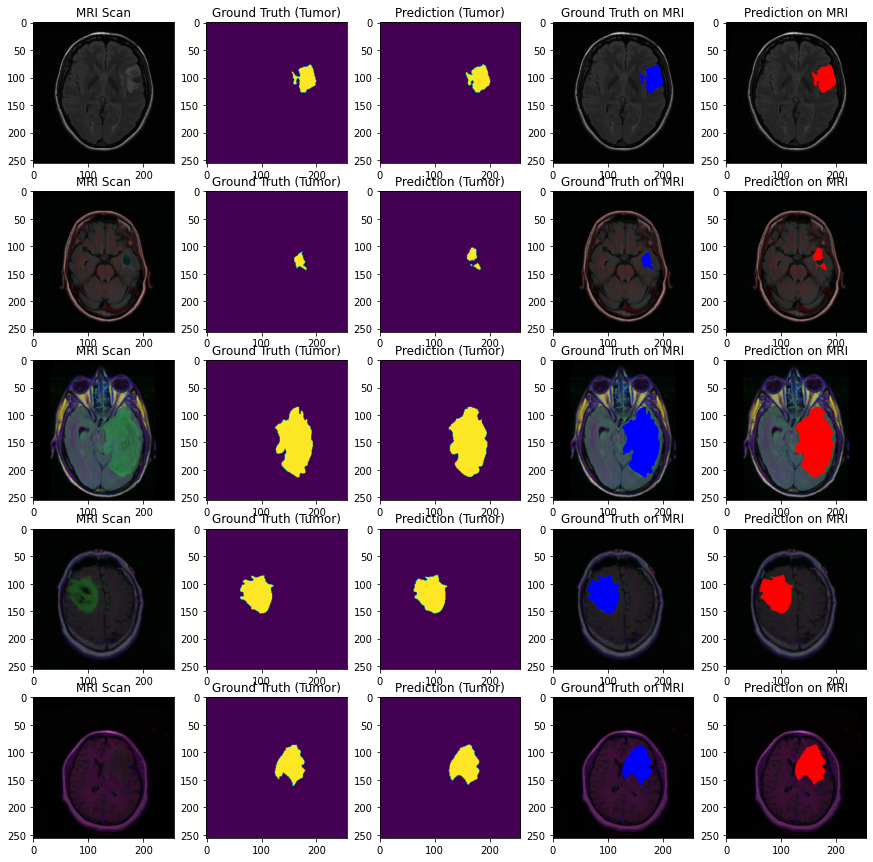

In [67]:
fig, ax = plt.subplots(5,5, figsize=(15,15))
counter = 0
for i in range(5):
  ## First dispaly MRI Scan
  mri = io.imread(visualization.image_path.values[i])
  ax[counter][0].title.set_text("MRI Scan")
  ax[counter][0].imshow(mri)

  ## Dispalying ground truth
  mask = io.imread(visualization.mask_path.values[i])
  ax[counter][1].title.set_text("Ground Truth (Tumor)")
  ax[counter][1].imshow(mask)

  ## Displaying predictions
  prediction = np.asarray(visualization.prediction.values[i])[0].squeeze().round()
  ax[counter][2].title.set_text("Prediction (Tumor)")
  ax[counter][2].imshow(prediction)

  ## Showing ground truth on mri scan
  mri[mask == 255] = (0, 0, 255)
  ax[counter][3].title.set_text("Ground Truth on MRI")
  ax[counter][3].imshow(mri)

  ## Showing predictions on mri
  mri = io.imread(visualization.image_path.values[i])
  mri[prediction == 1] = (255, 0, 0)
  ax[counter][4].title.set_text("Prediction on MRI")
  ax[counter][4].imshow(mri)

  counter += 1

In [108]:
## Evaluating mIoU of mask and prediction
from sklearn.metrics import jaccard_score
total = 0
score = []
for i in range(visualization.shape[0]):
  ground_truth = io.imread(visualization.mask_path.values[i])
  ground_truth = ground_truth / 255.
  prediction = np.asarray(visualization.prediction.values[i])[0].squeeze().round()
  for x in range(256):
    for y in range(256):
      if ground_truth[x][y] == 1 and prediction[x][y] == 1:
        total += 1
  score.append(total / ground_truth.sum())
  total = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [111]:
cleaned = [x for x in score if str(x) != 'nan']

In [112]:
print(sum(cleaned)/ len(cleaned))

0.9619787541196817
